# Arnoldi iteration

## Krylov subspace

Let's start with a matrix $A$ having known eigenvalues.

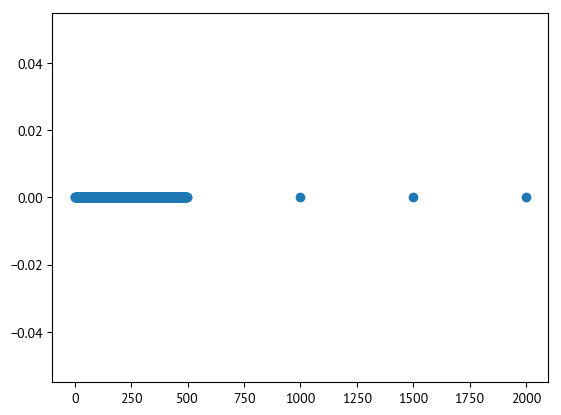

In [1]:
using LinearAlgebra
m = 500
A = diagm(0=>[1:m-3;2m;3m;4m],10=>ones(m-10))
λ = eigvals(Matrix(A))
using PyPlot
plot(real(λ),imag(λ),"o");

Suppose $A\in\mathbb{C}^{m\times m}$ and $b\in\mathbb{C}^m$ are given. The $n$th **Krylov subspace** $\mathcal{K}_n$ is the range of a certain $m\times n$ matrix:

In [3]:
b = ones(m)
K = b
n = 10
for j = 1:n-1
    K = [K A*K[:,j]];
end

One way to think of $K_n$ is as keeping a history of all the vectors found in the power iteration. For that reason, we suspect that it may be rich in content with the leading eigenvectors of $A$, much as with simultaneous iteration. In fact, the last column is essentially what we would get from power iteration, with a dominant eigenvalue estimate of

In [4]:
K[:,10]'*A*K[:,10]/(K[:,10]'*K[:,10])

1997.1931593723568

How could we use the rest of the information in $K_n$? Let's try projecting everything into its range. We'll use an orthonormal basis to reduce things to 10 dimensions.

In [5]:
U = svd(K).U;
@show size(U);

size(U) = (500, 10)


Given coordinates in this 10-dimensional space, we can convert them back to a vector in the large space, let $A$ operate on it, and then project back to our small space. That is, let

In [6]:
B = U'*A*U

10×10 Array{Float64,2}:
 1997.19           37.3701       -0.948225   …     0.0689708    -0.0519515
   37.3697       1499.76        -38.9584          -0.0492201     0.0394454
   -0.970238      -38.9386      992.729           -0.242246      0.0891795
   -0.0719462      -2.88742      73.6139          -1.46543       0.539434 
    0.00317346      0.127361     -3.24702         11.1215        1.20228  
    0.00534481      0.214504     -5.4687     …     7.79124      -5.90789  
   -0.001011       -0.0405745     1.03444        -63.4424       18.9552   
    0.000216428     0.00868593   -0.221445        91.7361       -9.16221  
    0.000208177     0.00835478   -0.213003       204.762      -105.789    
   -6.84924e-5     -0.00274881    0.0700801     -105.331       145.481    

be a 10-dimensional analog of $A$ on our little space. (One way to interpret this is as a multidimensional extension of the Rayleigh quotient.)

In [7]:
eigvals(B)

10-element Array{Float64,1}:
 1999.9999999661447  
 1500.000000689849   
  999.9998370809733  
  482.2730015599835  
  420.9208642359487  
  329.44685054657486 
  227.3606094551668  
  132.0184916842201  
   57.05768545571131 
   11.954509334111428

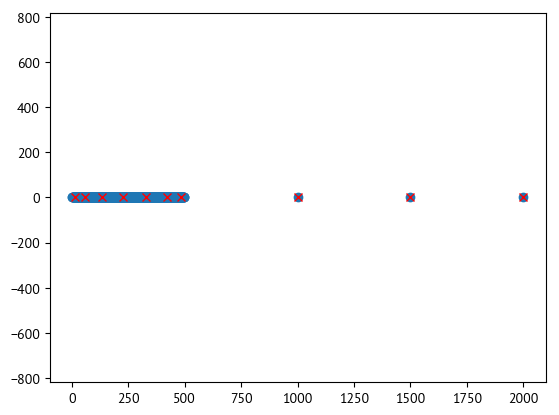

In [8]:
plot(real(λ),imag(λ),"o");
μ = eigvals(B)
plot(real(μ),imag(μ),"rx");

axis("equal");

That's a really interesting approximation of the full spectrum, coming from such a small representation!

## Arnoldi iteration

There's an Achilles heel in the little demo above:

In [9]:
cond(K)

3.91606075693941e30

That is...not a good basis to work with.

We'd like a (thin) QR factorization of $K_n$. But once $K_n$ has been computed in floating point, the ill conditioning is already baked in. Instead, we revisit the power/SI/Francis idea of reorthgonalizing after each application of $A$. 

Say $q_1,\ldots,q_j$ is an ONB for $\mathcal{K}_j$. By construction, $Aq_j\in \mathcal{K}_{j+1}$. Thus if $q_{j+1}$ extends the ONB to $\mathcal{K}_{j+1}$, it must be that

$$Aq_j = h_{1j} q_1 + \cdots + h_{nj} q_n + h_{j+1,j} q_{j+1}.$$

Furthermore, $h_{ij}=q_i^*Aq_j$. Written out for all $j=1,\ldots,n$, this implies 

$$AQ_n = Q_{n+1} \tilde{H}_n,$$

where $Q_j$ collects $q_1,\ldots,q_j$ and $\tilde{H}_n$ is an $(n+1)\times n$ upper Hessenberg matrix. Adapting the modified Gram-Schmidt algorithm, where the "new column" of a matrix comes from $A$ times the most recent column, we get the **Arnoldi iteration**.

In [11]:
function arnoldi(A,n)
    m = size(A,1)
    Q = zeros(m,n+1);
    H = zeros(n+1,n);
    Q[:,1] = b/norm(b);
    for j = 1:n
        v = A*Q[:,j]
        for i = 1:j
            H[i,j] = Q[:,i]'*v
            v = v - H[i,j]*Q[:,i]
        end
        H[j+1,j] = norm(v);
        Q[:,j+1] = v/H[j+1,j];
    end
    return H,Q
end

arnoldi (generic function with 1 method)

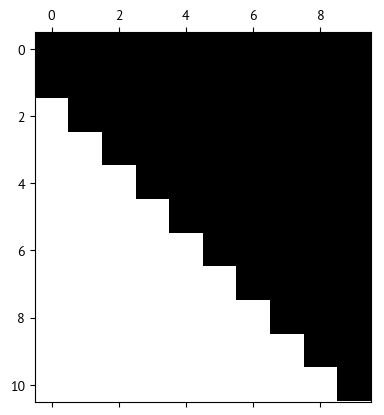

In [12]:
using PyPlot
H,Q = arnoldi(A,50)
spy(H[1:11,1:10]);

It's not hard to show that we can project $A$ into $\mathcal{K}_n$ (in the $Q_n$-basis) by 

$$Q_n^*AQ_n = Q_n^*Q_{n+1}\tilde{H}_n = H_n,$$

where $H_n$ is $\tilde{H}_n$ with the last row deleted. Eigenvalues of $H_n$ are eigenvalues of the action of $A$ as projected to $\mathcal{K}_n$. As $n\to\infty$, this begins to reveal some of the eigenvalues of $A$ itself. 

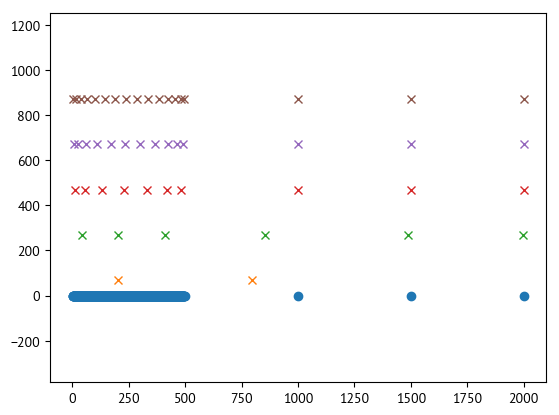

In [13]:
plot(real(λ),imag(λ),"o");
axis("equal")
for j = 2:4:18
    μ = eigvals(H[1:j,1:j])
    plot(real(μ),(50j-30) .+imag(μ),"x");
end

The big idea is to replace a problem on a very high-dimensional space, $\mathbb{C}^m$, with an approximating analog on a low-dimensional space, $\mathcal{K}_n$. For stability, this space is represented by means of an ON basis provided by the Arnoldi iteration.